In [34]:
# DATA Segment
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from scaler import StandardScalerLSTM

import gym
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import DQN
from stable_baselines.common.policies import FeedForwardPolicy
# from stable_baselines.deepq.policies import DQNPolicy
# from stable_baselines3.common.policies import ActorCriticPolicy

SEQ_LEN = 8
BATCH_SIZE = 16
FEATURE_SIZE = 12

In [4]:
# Check if CUDA (GPU support) is available
device = 'cpu'
if torch.cuda.is_available():
    print("CUDA is available! You can use the GPU.")
    device = 'cuda'
else:
    print("CUDA is not available. You'll be using CPU.")


CUDA is available! You can use the GPU.


In [5]:
data_df = pd.read_csv("data/final_dataset.csv")

data_df = data_df.drop(['Date'], axis=1)
data_df = data_df.iloc[1900:,:]
data = np.nan_to_num(np.array(data_df, dtype=np.float32))

# ====================== Scaler ========================

# Scaler
minmax_scaler = StandardScalerLSTM(batch_size=BATCH_SIZE, sequence_length=SEQ_LEN, feature_size=FEATURE_SIZE,device=device)
minmax_scaler.fit(data)

# ====================== Scaler ========================
def create_sequence(data,seq_len):
    xs = []
    ys = []
    for i in range(len(data)-seq_len-1):
        x = data[i:(i+seq_len),:]
        # print(x.shape)
        y = data[i+seq_len,0]
        xs.append(x)
        ys.append(y)
    return np.array(xs),np.array(ys)

inputs , targets = create_sequence(data,SEQ_LEN)
inputs=torch.from_numpy(inputs);targets=torch.from_numpy(targets)

In [6]:
data_df

,Open,High,Low,Close,MACD,ATR,RSI,EFFR,VIX,USDX,UNRATE,UMCSENT
1900,1283.21,1287.50,1256.98,1276.60,-4.820419,35.887857,30.130064,2.69,32.240002,71.459999,5.1,69.5
1901,1302.22,1330.74,1277.16,1330.74,-2.159744,32.133571,41.043854,2.16,25.790001,71.570000,5.1,69.5
1902,1334.63,1341.51,1298.42,1298.42,-3.087302,29.425714,33.795734,2.08,29.840000,72.139999,5.1,69.5
1903,1299.67,1330.67,1295.22,1329.51,-0.866801,27.663571,39.512096,2.22,26.620001,72.750000,5.1,69.5
1904,1333.66,1359.68,1330.29,1349.88,-0.276945,26.217143,55.488315,2.08,25.730000,72.949997,5.1,69.5
...,...,...,...,...,...,...,...,...,...,...,...,...
5840,4384.37,4391.20,4359.76,4382.78,-14.347386,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5841,4391.41,4393.40,4343.94,4347.35,-13.856403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5842,4364.15,4418.03,4353.34,4415.24,-8.206984,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5843,4406.66,4421.76,4393.82,4411.55,-5.370256,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# split the input data into train and test data
train_size = int(0.9 * len(inputs))
test_size = len(inputs) - train_size
train_inputs, test_inputs = inputs[:train_size], inputs[train_size:]
train_targets, test_targets = targets[:train_size], targets[train_size:]
print(train_inputs.shape, test_inputs.shape)

torch.Size([3542, 8, 12]) torch.Size([394, 8, 12])


In [8]:

# ====================== Model ======================== 
class PricePredictor(nn.Module):
    def __init__(self,scaler,batch_size, input_size=12, hidden_layer_size=150, time_segment=5, output_size=1):
        super().__init__()
        self.scaler = scaler
        self.hidden_layer_size = hidden_layer_size
        self.time_segment_length = time_segment
        self.lstm = nn.LSTM(input_size, hidden_layer_size,batch_first=True) # N x L x input_size(12)
        self.linear = nn.Linear(hidden_layer_size, output_size) # N x L x output_size(1)
        self.ReLU = nn.ReLU()
        # cell double is zeros vector of shape ((1, batch_size, hidden_layer_size), (1, batch_size, hidden_layer_size))
        self.cell_double =   (torch.zeros(1,batch_size,hidden_layer_size,requires_grad=False).to(device),
                              torch.zeros(1,batch_size,hidden_layer_size,requires_grad=False).to(device))
        self.remember = False 

    def forward(self, input_seq):
        '''
            input : N x L x input_size
            ouput : N x output_size
        '''
        input_seq = self.scaler(input_seq)

        if self.remember:
            output,self.cell_double = self.lstm(input_seq,self.cell_double) # N x L x hidden_layer_size
        else:
            output,_ = self.lstm(input_seq) # N x L x hidden_layer_size
        output = self.ReLU(output)
        self.cell_double = (self.cell_double[0].detach(),self.cell_double[1].detach())
        predictions = self.linear(output[:,-1,:].squeeze()) # N x output_size
        predictions = self.scaler.inverse_transform(predictions)
        hidden_state = output[:,-1,:].squeeze()  # Last hidden state
        return predictions, hidden_state

# ====================== Model ========================

In [9]:
def early_stopping(losses, patience=3):
    return patience < len(losses) and all([losses[-i-1] > losses[-i-2] for i in range(patience)])


/home/kanad/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test loss: 7950085.00000000
Test loss: 649534.62500000
Test loss: 709667.68750000
Test loss: 766250.12500000
Test loss: 743648.56250000
Test loss: 710578.25000000
Test loss: 710056.12500000
Test loss: 740869.62500000
Test loss: 790544.43750000
Test loss: 807959.00000000


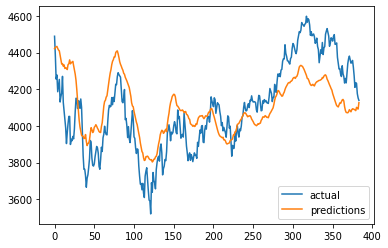

In [10]:
train_dataset = TensorDataset(train_inputs, train_targets)
test_dataset = TensorDataset(test_inputs, test_targets)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)


model = PricePredictor(minmax_scaler,BATCH_SIZE).to(device)
loss_function = nn.MSELoss()
# loss_function = nn.L1Loss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)

epochs = 80
test_losses = []

for i in range(epochs):
    for seq, targets in train_loader:
        if seq.shape[0]!=BATCH_SIZE: # if the last batch is not full
            continue
        seq, targets = seq.to(device), targets.to(device)
        optimizer.zero_grad()
        y_pred, hidden_state = model(seq)
        single_loss = loss_function(y_pred, targets)
        single_loss.backward()
        optimizer.step()

    if(i%5==0):
        # print the test loss
        with torch.no_grad():
            model.remember = True  # remember the last state of the cell
            test_loss_ = 0
            for seq_, targets_ in test_loader:
                if(seq_.shape[0]!=BATCH_SIZE): # if the last batch is not full
                    continue
                seq_, targets_ = seq_.to(device), targets_.to(device)
                y_pred_test, hid = model(seq_)
                test_loss_ += loss_function(y_pred_test, targets_)
                # print(y_pred_test.shape)
            print(f'Test loss: {test_loss_.item():10.8f}')
            test_losses.append(test_loss_.item())
            if early_stopping(test_losses, patience=3):
                break 
            model.remember = False # forget the last state of the cell for further training
    

torch.save(model.state_dict(), 'lstm_model.pth')

# ====================== Plot ========================
model.remember = True
actual_prices = []
predictions = []
with torch.no_grad():
    test_loss = 0
    for seq, targets in test_loader:
        seq, targets = seq.to(device), targets.to(device)
        if seq.shape[0]!=BATCH_SIZE: # if the last batch is not full
            continue
        y_pred, hid = model(seq)
        targets = targets.cpu().numpy()
        y_pred = y_pred.cpu().numpy()
        actual_prices.extend(targets.flatten())
        predictions.extend(y_pred.flatten())
    


actual_prices = np.array(actual_prices)
predictions = np.array(predictions)
x = np.arange(len(actual_prices))

plt.plot(x,actual_prices, label="actual")
plt.plot(x,predictions, label="predictions")
plt.legend()
plt.show()


In [11]:
lstm_model = PricePredictor(minmax_scaler,BATCH_SIZE).to(device)
lstm_model.load_state_dict(torch.load('lstm_model.pth'))
lstm_model.eval()  # Set the model to evaluation mode
lstm_model.to(device)

PricePredictor(
  (lstm): LSTM(12, 150, batch_first=True)
  (linear): Linear(in_features=150, out_features=1, bias=True)
  (ReLU): ReLU()
)

In [35]:
class CustomDQNPolicy(FeedForwardPolicy):
    def __init__(self, *args, **kwargs):
        super(CustomDQNPolicy, self).__init__(*args, **kwargs,
                                              net_arch=[32, 32],  # You can adjust these layers as needed
                                              feature_extraction="custom", n_env=1, n_steps=1, n_batch=1)  # Using MLP for processing LSTM output

    def extract_features(self, obs):
        # Assuming 'obs' is the hidden state from your LSTM model
        # You can add additional processing here if needed
        return obs

In [13]:
# class CustomDQNPolicy(FeedForwardPolicy):
#     def __init__(self, *args, **kwargs):
#         super(CustomDQNPolicy, self).__init__(*args, **kwargs,
#                                               net_arch=[32, 32],  # Adjust layers as needed
#                                               feature_extraction="custom")
#         # Initialize LSTM Model

#         self.lstm_model = PricePredictor(minmax_scaler,BATCH_SIZE).to(device)
#         self.lstm_model.load_state_dict(torch.load('lstm_model.pth'))
#         self.lstm_model.eval()  # Set the model to evaluation mode
#         self.lstm_model.to(device)
#         # self.lstm_model = LSTMModel(input_size=obs_size, hidden_layer_size=hidden_state_size)
#         # Load trained LSTM model here if you have one

#     def extract_features(self, obs):
#         # Process observation through LSTM and extract hidden state
#         hidden_state = self.lstm_model(obs)
#         return hidden_state

In [31]:
import gym
from gym import spaces
import numpy as np
import torch

class CustomStockEnv(gym.Env):
    def __init__(self, price_predictor, df, frame_bound, window_size):
        super(CustomStockEnv, self).__init__()
        self.price_predictor = price_predictor
        self.df = df
        self.frame_bound = frame_bound
        self.window_size = window_size
        self.current_step = frame_bound[0]
        self.last_price = df.iloc[self.current_step]['Close']
        self.current_price = df.iloc[self.current_step]['Close']

        # Define action and observation space
        # Example: 3 actions (buy, hold, sell)
        self.action_space = spaces.Discrete(3)
        
        # Assuming the LSTM hidden state size is 150 (as defined in PricePredictor)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(150,), dtype=np.float32)

    def step(self, action):
        self.current_step += 1
        done = self.current_step >= self.frame_bound[1]
        current_data = self.df.iloc[self.current_step - self.window_size:self.current_step]

        # Process current data as required by your LSTM model
        # Assuming current_data is a DataFrame, converting it to a tensor
        current_data_tensor = torch.tensor(current_data.values, dtype=torch.float32).unsqueeze(0)

        # Use the LSTM model to get the hidden state
        _, hidden_state = self.price_predictor(current_data_tensor)

        # Calculate reward (you need to define how to do this)
        reward = self.calculate_reward(action, hidden_state)

        # Additional info, if any
        info = {}
        
        return hidden_state.detach().numpy(), reward, done, info

    def reset(self):
        self.current_step = self.frame_bound[0]
        initial_data = self.df.iloc[self.current_step - self.window_size:self.current_step]
        initial_data_tensor = torch.tensor(initial_data.values, dtype=torch.float32).unsqueeze(0)
        _, hidden_state = self.price_predictor(initial_data_tensor)
        
        return hidden_state.detach().numpy()

    def render(self, mode='human'):
        # Optional: Implement rendering logic, if needed
        pass

    def calculate_reward(self, action, hidden_state):
        # Define your reward calculation logic based on the action and hidden state
        # Placeholder example:


        # current_price = self.get_current_price()
        # last_price = self.get_last_price()
        current_price = self.df.iloc[self.current_step]['Close']
        percentage_change = (current_price - last_price) / last_price

        if action == 1:  # Buy
            reward = -percentage_change
            last_price = current_price
        elif action == 2:  # Sell
            reward = percentage_change
            last_price = current_price
        else:  # Hold
            reward = 0
        
        return reward


In [37]:

# Create and wrap the environment
data_df = pd.read_csv("data/final_dataset.csv")
data_df = data_df.drop(['Date'], axis=1)
start = 1900
end = data_df.size - 1
env = CustomStockEnv(lstm_model, data_df, frame_bound=(start, end), window_size=SEQ_LEN)
env = DummyVecEnv([lambda: env])
print(env)
# Initialize the DQN model with the custom policy
model = DQN(CustomDQNPolicy, env, verbose=1)

# Train the agent
model.learn(total_timesteps=100000)


Using cuda device


/home/kanad/.local/lib/python3.8/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


TypeError: __init__() missing 3 required positional arguments: 'n_env', 'n_steps', and 'n_batch'

In [ ]:
# import gym
# from stable_baselines.common.vec_env import DummyVecEnv
# from stable_baselines import DQN

# # Set up your environment
# env = gym.make('stocks-v0')
# env = DummyVecEnv([lambda: env])

# # Initialize the DQN model with the custom policy
# model = DQN(CustomDQNPolicy, env, verbose=1)

# # Train the agent
# model.learn(total_timesteps=100000)

In [ ]:
# Assuming you have a separate DataFrame `df_test` for testing
test_env = CustomStockEnv(lstm_model, data_df, frame_bound=(start, end), window_size=SEQ_LEN)
test_env = DummyVecEnv([lambda: test_env])

In [ ]:
total_rewards = []
num_episodes = 100  # Define the number of episodes for testing

for episode in range(num_episodes):
    obs = test_env.reset()
    done = False
    total_reward = 0

    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, info = test_env.step(action)
        total_reward += reward

    total_rewards.append(total_reward)

# Calculate average reward
average_reward = np.mean(total_rewards)
print("Average reward per episode:", average_reward)